# Robbing the Fed: Directly Obtaining Private Data in Federated Learning with Modified Models

This notebook shows an example for the threat model and attack described in "Robbing the Fed: Directly Obtaining Private Data in Federated Learning with Modified Models". This example deviates from the other "honest-but-curious" server models and investigates an actively malicious model. As such, the attack applies to any model architecture, but its impact is more or less obvious (or not at all) depending on the already present architecture onto which the malicious "Imprint" block is grafted.

In this notebook, we place the block in front of a ResNet18, as an example.


Paper URL: https://openreview.net/forum?id=fwzUgo0FM9v

This variation implements an attack against user updating their models based on federated averaging. This threat model is only relevant if the user 

 * forces a federated averaging update with non-zero step size (but usually the server sets the step size)
 * forces an update on all model parameters in intermediate update steps (but the server might send different instructions)
 * has a model where the gradient signal coming to the imprint block is large enough to move these parameters.

Under these condiditions, the attack success is decreased, as bins drift away from their optimal choice, yet the attack still recovers large amounts of private data.

### Abstract:

Federated learning has quickly gained popularity with its promises of increased user privacy and efficiency.  Previous works have shown that federated gradient updates contain information that can be used to approximately recover user data in some situations.  These previous attacks on user privacy have been limited in scope and do not scale to gradient updates aggregated over even a handful of  data  points,  leaving  some  to  conclude  that  data  privacy  is  still  intact  for realistic training regimes.  In this work, we introduce a new threat model based on minimal but malicious modifications of the shared model architecture which enable the server to directly obtain a verbatim copy of user data from gradient updates without solving difficult inverse problems.  Even user data aggregated over large batches – where previous methods fail to extract meaningful content – can be reconstructed by these minimally modified models.

### Startup

In [28]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [29]:
cfg = breaching.get_config(overrides=["attack=imprint", "case/server=malicious-model-rtf", 
                                      "case/user=local_updates"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type malicious_model.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [30]:
cfg.case.user.num_data_points = 64 # How many data points does this user own

# FL setup:
cfg.case.user.num_local_updates = 8
cfg.case.user.num_data_per_local_update_step = 64
cfg.case.user.local_learning_rate = 1e-4


cfg.case.server.model_modification.type = 'SparseImprintBlock'
cfg.case.server.model_modification.num_bins = 128 # How many bins are in the block


# How does the block interact with the model?
# The block can be placed later in the model given a position such as  '4.0.conv':
cfg.case.server.model_modification.position = None  # None defaults to the first layer
# The block can also be connected in various ways to the other layers:
cfg.case.server.model_modification.connection = 'linear'



# Which linear measurement function should be used? 
# We know that the input dataset is already normalized as preprocessing step

# Knowing the distribution relatively well:
cfg.case.server.model_modification.linfunc = 'fourier' # works well for any normalized image data
cfg.case.server.model_modification.mode = 32

# # Eyeballing the distribution based on the law of large numbers:
# cfg.case.server.model_modification.linfunc = 'randn' # will work decently for anything
# cfg.case.server.model_modification.mode = None

# Let's check what happens when we set the shuffling False to true.
cfg.case.impl.shuffle =True
cfg.case.user.user_idx = 23

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [31]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

First layer determined to be model.conv1
Block inserted at feature shape torch.Size([3, 224, 224]).
Model architecture ResNet18 loaded with 50,065,997 parameters and 9,620 buffers.
Overall this is a data ratio of       5:1 for target shape [64, 3, 224, 224] given that num_queries=1.
User (of type UserMultiStep) with settings:
    Number of data points: 64

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 23
    
        
    Local FL Setup:
        Number of local update steps: 8
        Data per local update step: 64
        Local learning rate: 0.0001

        Threat model:
        Share these hyperparams to server: True

        
Server (of type MaliciousModelServer) with settings:
    Threat model: Malicious (Analyst)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [32]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

Computing user update on user 23 in model mode: eval.


In [33]:
local_user_dataa = cfg.case.data

In [34]:
aa = user._load_data()
print(aa['labels'])

tensor([347,  31,  29, 236, 282, 104, 361, 293, 326, 200, 156, 353,  79, 254,
         37, 359, 255,  32,  73, 248,  44, 306,  42, 273, 162,   2, 120, 333,
        172, 277, 134, 284, 166,  83,  66,  90, 323, 350,   1, 264, 304, 202,
        115, 279, 246,  59,  39, 327, 224, 241, 285,  77, 232, 103, 239, 207,
         35, 298, 250,  62, 135, 369,  61, 150], device='cuda:0')


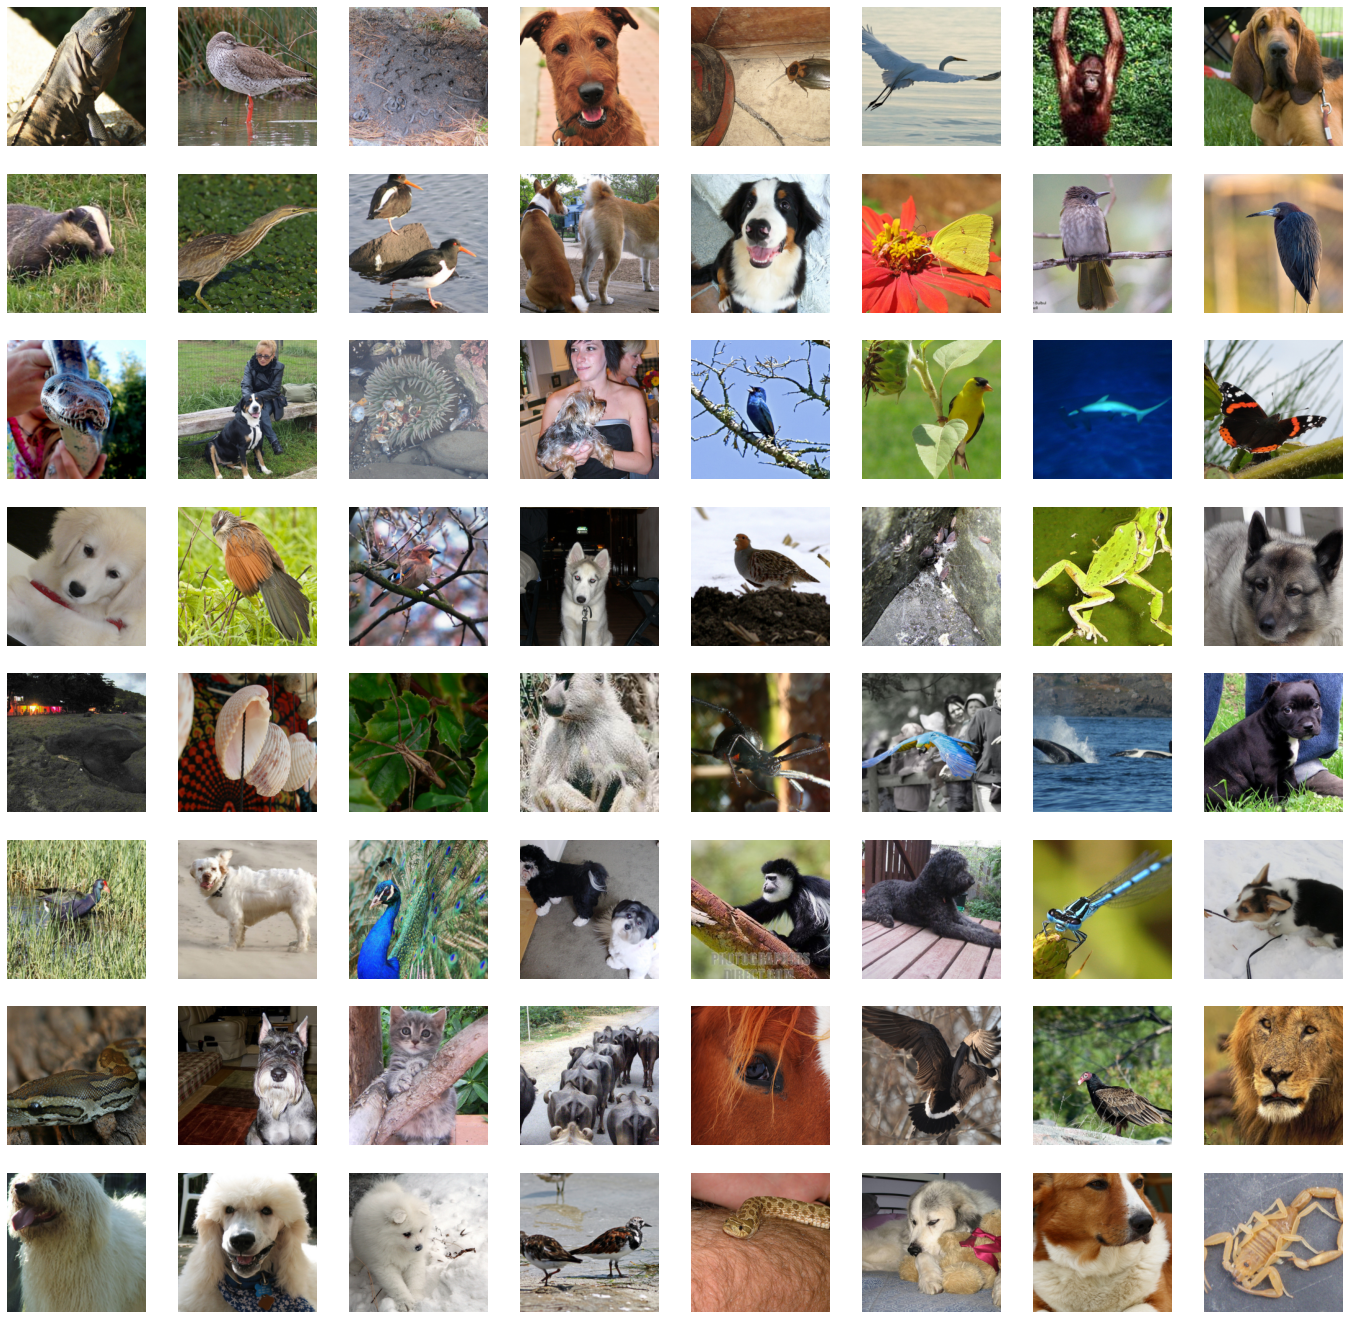

In [35]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

For this attack, we also share secret information from the malicious server with the attack (`server.secrets`), which here is the location and structure of the imprint block.

In [36]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], server.secrets, 
                                                      dryrun=cfg.dryrun)

Initially produced 51 hits.


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [37]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0235 | PSNR: 25.14 | FMSE: 8.6912e+01 | LPIPS: 0.26|
 R-PSNR: 25.38 | IIP-pixel: 76.56% | SSIM: 0.7022 | max R-PSNR: 64.57 | max SSIM: 1.0000 | Label Acc: 0.00%


And finally, we also plot the reconstructed data:

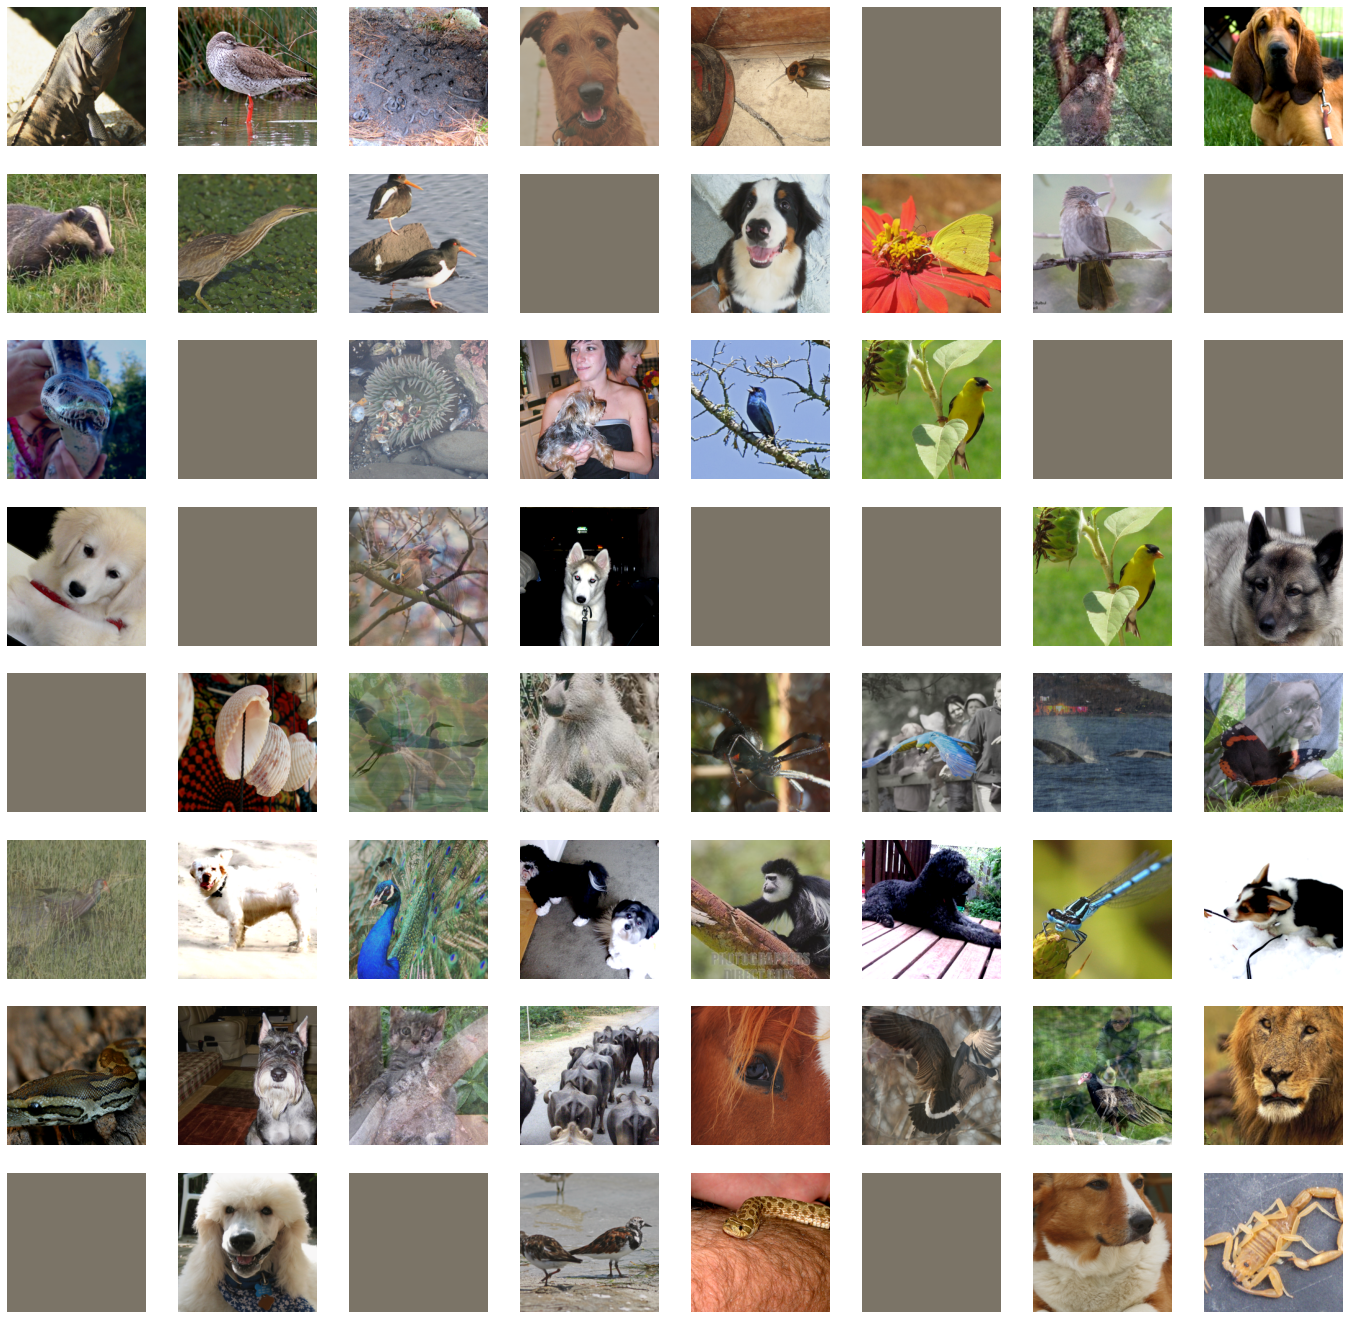

In [38]:
user.plot(reconstructed_user_data)

### Notes:
* It is also ok to use the non-sparse default `ImprintBlock` here, but probably best to also modify the connection to be `addition` when doing so, to prevent the local model from diverging to NaN gradients before the attack has even started.


In [39]:
print((cfg.attack.attack_type))

imprint-readout
